***
# <font color='blue'>DNMT trial stimulation history effects analysis upon CG silencing 
***   
#### We are testing whether silencing the CG, either during the sample or choice period will influence the following trials. 
#### We will look into this putative trial stimulation history effect across all of the trials but also across the trials
#### (in blocks of 50 trials, as in the performance across trials analysis).
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import scipy.stats as stats
import os
import re

from file_lists import get_file_list
%matplotlib inline

***
#### Created a function to collect all trials from all rats of given experimental group. For each rat and stimulation condition, add a trial number from 1 to n, being n the total number of trials per condition for each rat.
***

In [2]:
def collect_trial_data(folder_dir):
      
    # Get directories of each rat folder inside group folder (condition folders: CTRL, EXP)
    rat_folders = os.listdir(folder_dir)
    rat_dirs = [os.path.join(folder_dir, x) for x in rat_folders]
  
    # For each subject, collect trial data
    data = []
    
    for path in rat_dirs:
    
        id = re.search(r"(\w+#\d)", path)
        file_list = get_file_list(path, '*.csv')
        file_list.sort()
        all_sessions_list = []
        # Collect data in the form of a dataframe from every single file the rat folder
        for filename in file_list:
            
            session = pd.read_csv(os.path.join(path, filename), names=['sample', 'stim', 'outcome'], header=None)    
            
            # Add the session label to the 'session' column in the dataframe
            session_code = re.search(r"_(\d+).", filename)
            session['session'] = session_code[1]
            
            try:
                all_sessions_list.append(session)
            except:
                all_sessions_list = session
        
        all_sessions_rat = pd.concat(all_sessions_list)
        all_sessions_rat['rat'] = id[0]

        # Add a trial number given the stimulation condition
        for cond in all_sessions_rat['stim'].unique():
            
            trial_numbers = list(range(1,len(all_sessions_rat[all_sessions_rat['stim'] == cond])+1))
            all_sessions_rat.loc[all_sessions_rat['stim'] == cond, 'trial_nr_stim'] = trial_numbers
            
        try:
            data.append(all_sessions_rat)
        except:
            data = all_sessions_rat
                      
    return pd.concat(data) 

***
#### Apply function to both experimental groups. Label each trial as 'control' or 'nphr' according to the experimental group. Then concatenate both dataframes
***

In [3]:
# Collect trial data for each experimental group
ctrl_dir="E:\PERFORMANCE_LOGS\\CTRL"
nphr_dir="E:\PERFORMANCE_LOGS\\EXP"

ctrl_trials = collect_trial_data(ctrl_dir)
nphr_trials = collect_trial_data(nphr_dir)

# Add experimental group label and concatenate both dataframes into one
ctrl_trials['group'] = 'control'
nphr_trials['group'] = 'nphr'
all_trials = pd.concat([ctrl_trials, nphr_trials])

# Remove NPHR#3 
all_trials = all_trials[all_trials['rat']!='NPHR#3']

In [4]:
# Remove trials in which the rat was stimulated during the delay period
# Because of the low numbers of sample stimulation in the control group, these will be temporarily removed!
conditions_to_keep_mask = ((all_trials['stim'] == 0) | (all_trials['stim'] == 3))
trials = all_trials[conditions_to_keep_mask]

***
#### Create two new columns containing the stimulation information regarding the previous two trials by shifting the "stim" column by either one or two rows, for each session. After, calculate the probability of a correct trial given the previous trial stimulation

In [5]:
# Shift the "stim" column to create the "t-1" column
trials['t-1_stim'] = trials.groupby('session')['stim'].shift(1)
# Check the number of trials in each subgroup
trials.groupby(['group','rat','t-1_stim','stim'])['outcome'].count()

C:\Users\anasofiaccruz\Anaconda3\envs\pycharm\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


group    rat     t-1_stim  stim
control  CTRL#1  0.0       0        43
                           3        31
                 3.0       0        30
                           3        16
         CTRL#2  0.0       0        77
                           3       116
                 3.0       0       113
                           3        80
nphr     NPHR#1  0.0       0        46
                           3        29
                 3.0       0        28
                           3        18
         NPHR#2  0.0       0        14
                           3        22
                 3.0       0        22
                           3        15
         NPHR#4  0.0       0        55
                           3        88
                 3.0       0        81
                           3        57
         NPHR#5  0.0       0        64
                           3        86
                 3.0       0        84
                           3        58
         NPHR#6  0.0       0    

In [6]:
sums = trials.groupby(['group', 'rat', 't-1_stim'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 't-1_stim'])['outcome'].count()                      
probabilities= ((sums/total)*100).reset_index()

# 1. 
***
### Probability of a correct trial given the previous trial stimulation (regardless of the current trial condition)
***

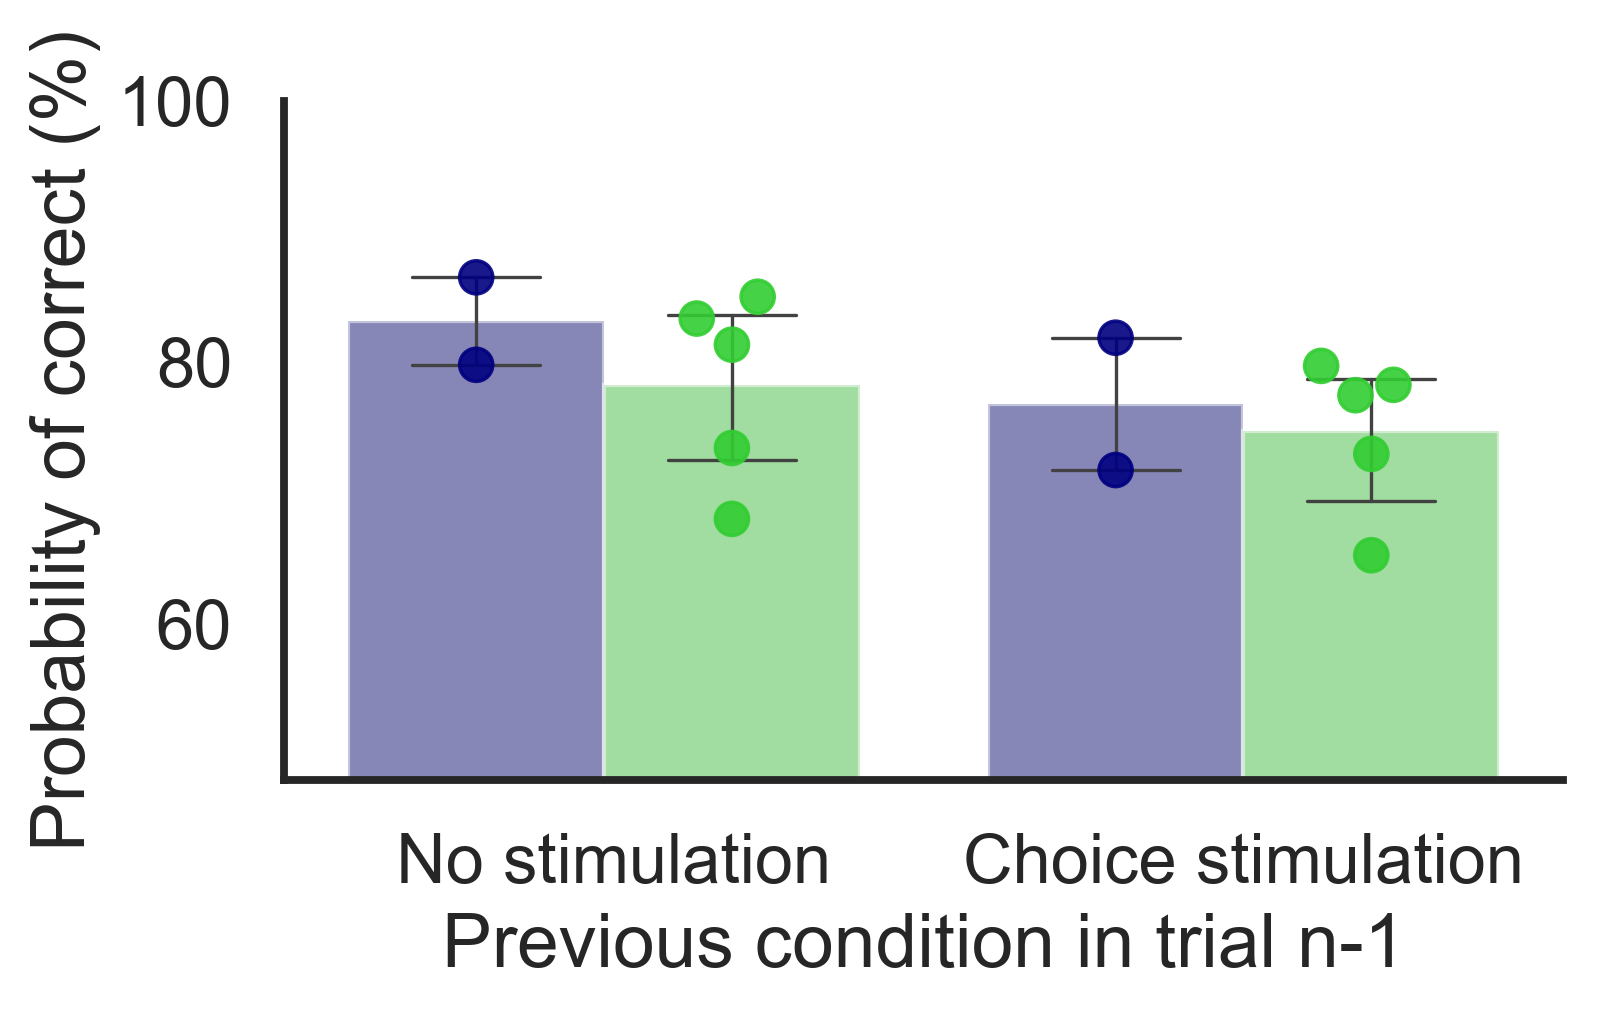

In [7]:
sns.set(style="white", context='talk')
plt.figure(figsize=(5.5,3), dpi=300)

a = sns.barplot(
    x='t-1_stim', y='outcome', hue='group', data=probabilities,
    palette=['navy', 'limegreen'], alpha=.5,
    errwidth=.8, capsize=.2, linewidth=1, edgecolor='w'
)

b = sns.swarmplot(
     x='t-1_stim', y='outcome', hue='group', data=probabilities,
     palette=['navy', 'limegreen'],
     edgecolor=None, alpha=.9, linewidth=.8,
     s=8, dodge=True
   
)

a.set(
    ylabel='Probability of correct (%)', xlabel='Previous condition in trial n-1',
    ylim=(48, 100), xlim=(-0.5, 1.5)
)

a.legend_.remove()
a.set_xticklabels(labels=[' No stimulation', 'Choice stimulation'], rotation=0)
sns.despine()
plt.show()

# 2.

***
## When there is no silencing of CG in the current trial, what is the probability of having a correct trial given the previous stimulation conditions?
***


In [8]:
sums = trials.groupby(['group', 'rat', 't-1_stim', 'stim'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 't-1_stim','stim'])['outcome'].count()                      
probabilities_t1= ((sums/total)*100).reset_index()

      group     rat  t-1_stim  stim    outcome
0   control  CTRL#1       0.0     0  93.023256
2   control  CTRL#1       3.0     0  70.000000
4   control  CTRL#2       0.0     0  80.519481
6   control  CTRL#2       3.0     0  80.530973
8      nphr  NPHR#1       0.0     0  71.739130
10     nphr  NPHR#1       3.0     0  75.000000
12     nphr  NPHR#2       0.0     0  78.571429
14     nphr  NPHR#2       3.0     0  77.272727
16     nphr  NPHR#4       0.0     0  76.363636
18     nphr  NPHR#4       3.0     0  76.543210
20     nphr  NPHR#5       0.0     0  85.937500
22     nphr  NPHR#5       3.0     0  80.952381
24     nphr  NPHR#6       0.0     0  86.666667
26     nphr  NPHR#6       3.0     0  86.075949


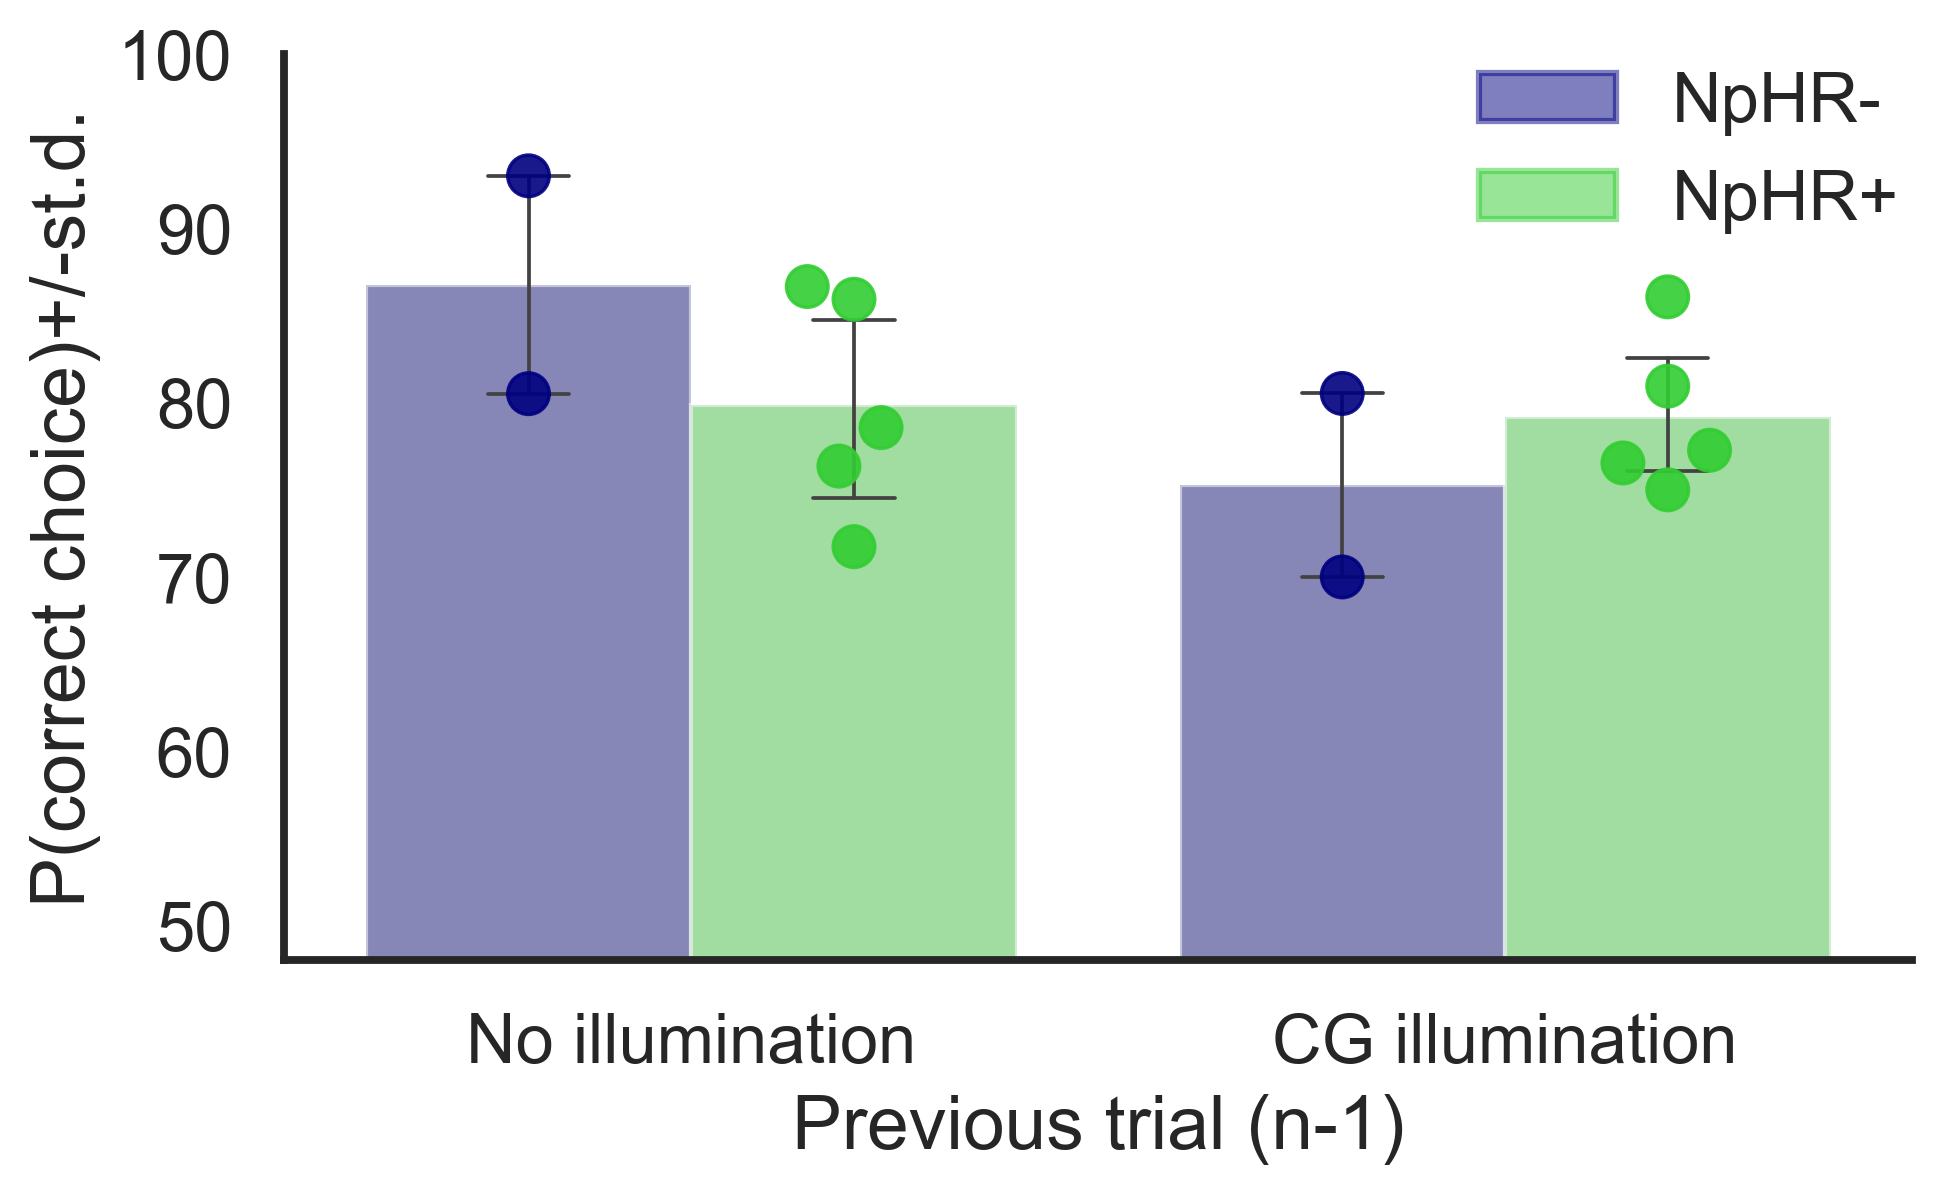

In [14]:
probabilities_t_no_stim = probabilities_t1[probabilities_t1['stim']==0]
print(probabilities_t_no_stim)
sns.set(style="white", context='talk')
plt.figure(figsize=(7,4), dpi=300)

a = sns.barplot(
    x='t-1_stim', y='outcome', hue='group', data=probabilities_t_no_stim,
    palette=['navy', 'limegreen'], alpha=.5,
    errwidth=.9, capsize=.1, linewidth=1, edgecolor='w'
)

b = sns.swarmplot(
     x='t-1_stim', y='outcome', hue='group', data=probabilities_t_no_stim,
     palette=['navy', 'limegreen'],
     edgecolor=None, alpha=.9, linewidth=.8,
     s=10, dodge=True
   
)

a.set(
    ylabel='P(correct choice)+/-st.d.', xlabel='Previous trial (n-1)',
    ylim=(48, 100), xlim=(-0.5, 1.5)
)

a.set_xticklabels(labels=['No illumination', 'CG illumination'], rotation=0)
#a.set_title('Prob. correct trial when current trial is non stimulation')

# ------------------------------------- LEGEND -------------------------------------------- 
a.legend_.remove()

control_line = mpatches.Patch(color='navy', label='NpHR-', alpha=.5)
nphr_line = mpatches.Patch(color='limegreen', label='NpHR+', alpha=.5)
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.03, 1.05))

sns.despine()
plt.show()

In [10]:

trials.loc[trials['trial_nr_stim'].between(0,50), 'trial_intervals'] = 0
trials.loc[trials['trial_nr_stim'].between(51,100), 'trial_intervals'] = 1
trials.loc[trials['trial_nr_stim'].between(101,150), 'trial_intervals'] = 2
sums = trials.groupby(['group', 'rat', 't-1_stim', 'stim', 'trial_intervals'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 't-1_stim','stim', 'trial_intervals'])['outcome'].count()

prob_correct_giv_prev_trial_intervals= ((sums/total)*100).reset_index()

C:\Users\anasofiaccruz\Anaconda3\envs\pycharm\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\anasofiaccruz\Anaconda3\envs\pycharm\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 3.
***
### Progression of the previous trial (n-1) effect when CG is silenced during choice at trial (n-1) for the nphr group
***

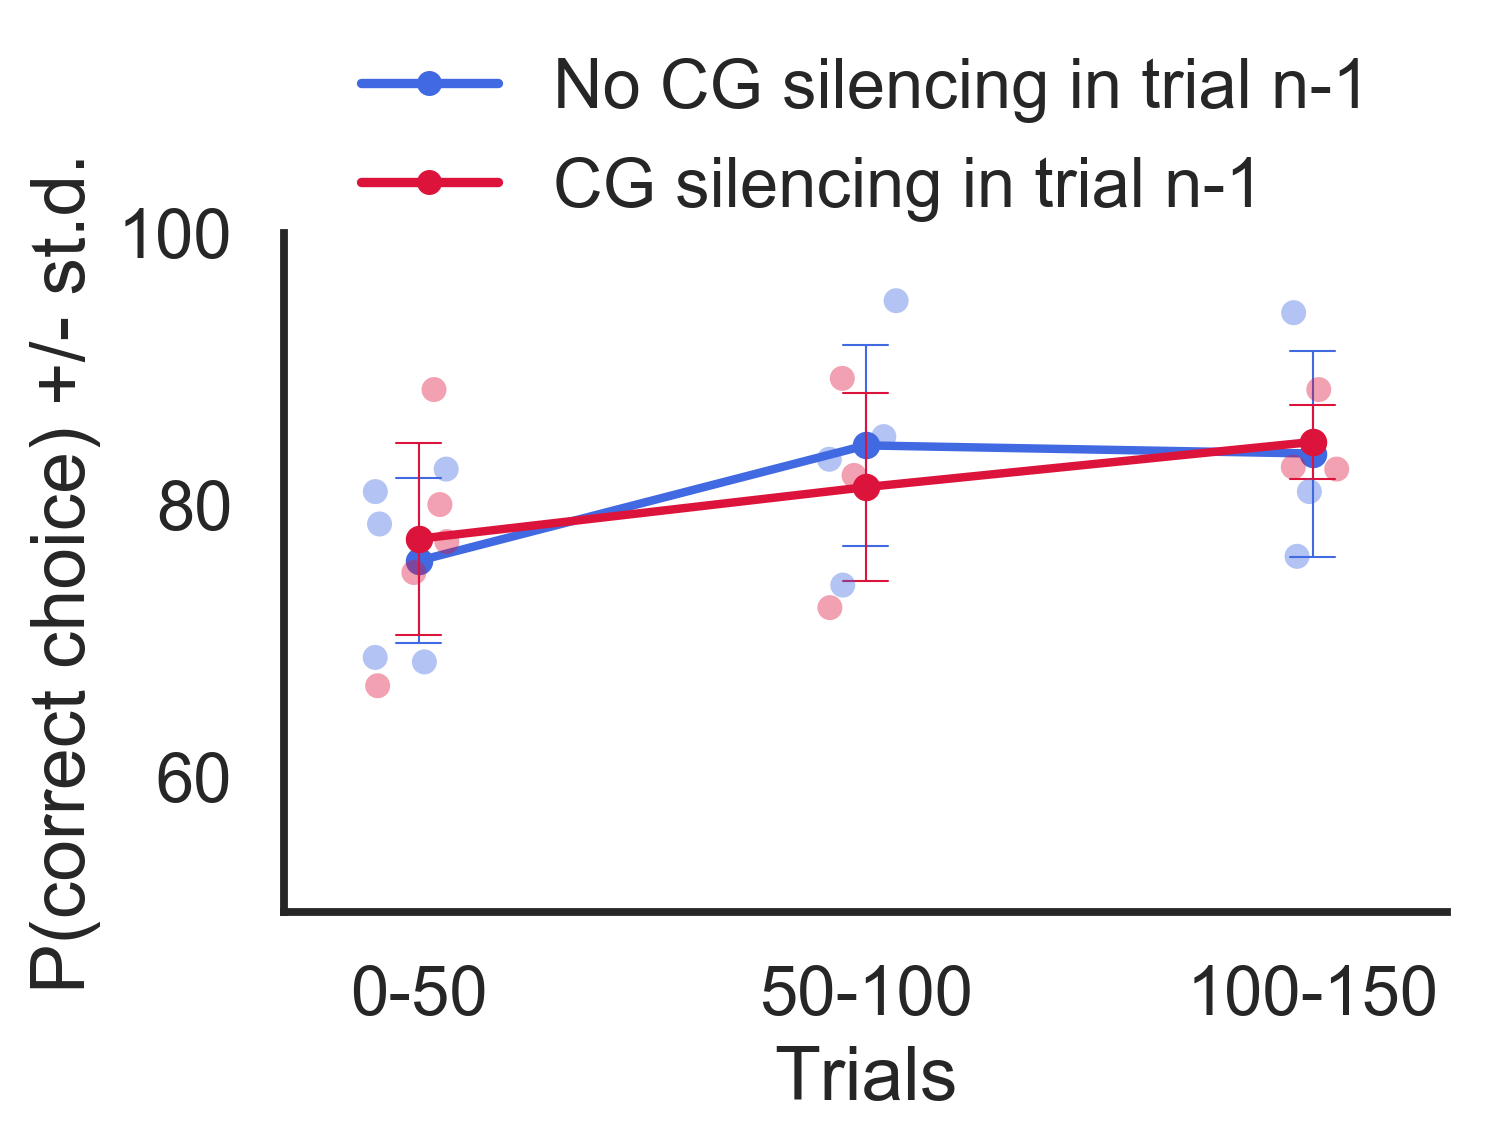

In [11]:
#Collect data only from stim in current trial == 0
mask = (prob_correct_giv_prev_trial_intervals['stim'] == 0) & (prob_correct_giv_prev_trial_intervals['group'] == 'nphr')
df = prob_correct_giv_prev_trial_intervals[mask]
sns.set(style="white", context='talk')
plt.figure(figsize=(5,3), dpi=300)

g = sns.stripplot(
    x='trial_intervals', y='outcome', hue='t-1_stim', data=df,
    palette=['royalblue', 'crimson'],
    jitter=.1, alpha=.4, s=6
)
    
# Show means. 1st color=0, 2nd color=sample, 3rd color=test
sns.pointplot(
    x='trial_intervals', y='outcome', hue='t-1_stim', data=df, 
    dodge=False, join=True,            
    markers="o", scale=.5,  alpha=.7,
    ci='sd', errwidth=.5, capsize=.1,
    palette=['royalblue', 'crimson']
)

g.set(
    xlim=(-0.3,2.3), ylim=(50,100),
    ylabel='P(correct choice) +/- st.d.', xlabel='Trials',
    #title='Prob.correct trial(n) when the CG is silenced during choice at the previous (n-1) and current (n) trial'
)

g.set_xticklabels(['0-50', '50-100', '100-150'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()
nostim_line = mlines.Line2D([], [], color='royalblue', marker='o', markersize=5, label='No CG silencing in trial n-1')
choicestim_line = mlines.Line2D([], [], color='crimson', marker='o', markersize=5, label='CG silencing in trial n-1')
plt.legend(handles=[nostim_line, choicestim_line], frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.35))

sns.despine()
plt.show()

# 4.
***
***

In [12]:
trials['t-1_outcome'] = trials['outcome'].shift(1)
sums = trials.groupby(['group', 'rat', 'stim', 't-1_outcome'])['outcome'].sum()
total = trials.groupby(['group', 'rat', 'stim', 't-1_outcome'])['outcome'].count()

df= ((sums/total)*100).reset_index()

C:\Users\anasofiaccruz\Anaconda3\envs\pycharm\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 2400x2400 with 0 Axes>

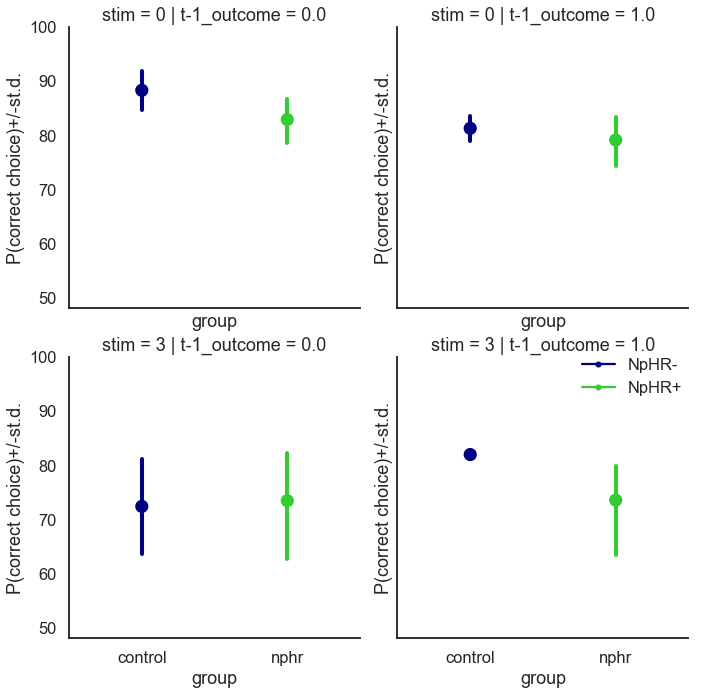

In [13]:
sns.set(style="white", context='talk')
plt.figure(figsize=(8,8), dpi=300)

a = sns.catplot(
    kind='point',
    data=df, x='group', y='outcome',
    col='t-1_outcome', row='stim',
    palette=['navy', 'limegreen'], alpha=.9,
    linewidth=1, edgecolor=None
)


a.set(
    ylabel='P(correct choice)+/-st.d.', xlabel='group',
    ylim=(48, 100), xlim=(-0.5, 1.5)
)

#a.set_xticklabels(labels=['Error', 'Rewarded'], rotation=0)
#a.set_title('Prob. correct trial when current trial is non stimulation')

# ------------------------------------- LEGEND -------------------------------------------- 
#a.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=5, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='limegreen', marker='o', markersize=5, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.03, 1.05))

sns.despine()
plt.show()